# Air Pressure System (APS) Failure for Scania Trucks  
**Predict Failures and Minimize Costs based on Sensor Readings**

## 1. DATA PREPROCESSING

**DOWNLOAD DATA**

Download train data and test data from https://archive.ics.uci.edu/ml/machine-learning-databases/00421/ and store those downloaded .csv file in the 'data' folder

**IMPORT LIBRARY**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt

from imblearn.over_sampling import SMOTE

**SET SEED**

In [2]:
np.random.seed(2022)

**IMPORT DATA**  
Import train data and test data from .csv file downloaded.

> ***Train Data***

In [3]:
train_data = pd.read_csv('../data/aps_failure_training_set.csv',skiprows=20,na_values="na")
train_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


> ***Test Data***

In [4]:
test_data = pd.read_csv('../data/aps_failure_test_set.csv',skiprows=20,na_values="na")
test_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


### TRAIN DATA PREPROCESSING

**MISSING VALUE**

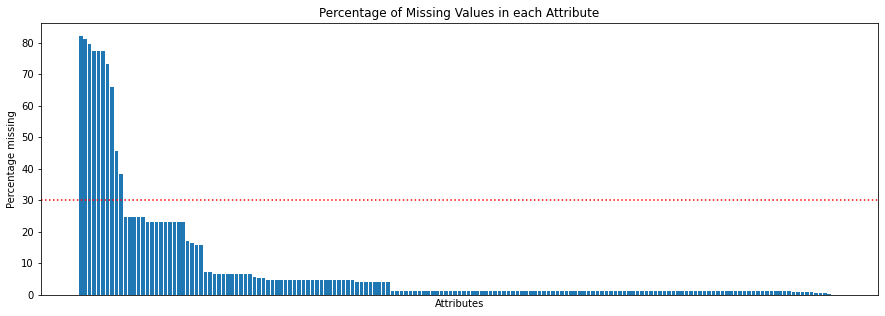

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
threshold = 30

# Calculate % of missing values for each attribute
missing = train_data.isna().sum().div(train_data.shape[0]).mul(100).to_frame().sort_values(by=0,ascending = False )

ax.bar(missing.index, missing.values.T[0])
plt.title("Percentage of Missing Values in each Attribute")
plt.xticks([])
plt.xlabel("Attributes")
plt.ylabel("Percentage missing")
plt.axhline(threshold, color='red', ls='dotted')
plt.show()

Count amount of columns that contain missing values more than 30%.

In [6]:
# Store index of columns that contain missing values more than threshold.
cols_missing_30 = missing[missing[0]>30].index
no_cols_na = len(cols_missing_30)

# Count and print amount of column more than threshold.
print("There are {0} columns contain missing values more than {1}%.".format(no_cols_na,threshold))

There are 10 columns contain missing values more than 30%.


In [7]:
cols_missing_30

Index(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000',
       'bm_000', 'bl_000', 'bk_000'],
      dtype='object')

**DROP COLUMNS**  
Drop columns that contain missing values more than 30%.

In [8]:
# Drop columns that contain missing values more than 30%.
train_data_drp30 = train_data.drop(cols_missing_30, axis=1)

# Validate only selected column is removed.
train_data_drp30.shape

(60000, 161)

**REPLACE MISSING VALUES**  
Replace leftover missing values with median.

In [9]:
# Replace leftover missing values with median.
train_data_fillna = train_data_drp30.fillna(train_data_drp30.median(), inplace=False)

# Validate no missing values left
train_data_fillna.isnull().sum().sum()

0

**ENCODING CATEGORICAL DATA**  
Encode categorical data into numeric type data.

In [10]:
# Check categorical column in data
train_data_fillna.info()
train_data_fillna['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 161 entries, class to eg_000
dtypes: float64(159), int64(1), object(1)
memory usage: 73.7+ MB


neg    59000
pos     1000
Name: class, dtype: int64

In [11]:
# Replace class label from (neg,pos) to (0,1)
train_data_encode = train_data_fillna.replace('neg',0).replace('pos',1)

# Validate no categorical data left.
train_data_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 161 entries, class to eg_000
dtypes: float64(159), int64(2)
memory usage: 73.7 MB


**SPLIT TARGET VARIABLE IN TRAIN DATA**  
Split train data to x_train and y_train

In [12]:
x_train = train_data_encode.drop('class', axis=1)
x_train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058,0.000000e+00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [13]:
y_train = train_data_encode.iloc[:,0]
y_train.head()
y_train.value_counts()

0    59000
1     1000
Name: class, dtype: int64

**FEATURE SCALING WITH STANDARDIZATION**  
For every feature, all value gets rescale to mean value of 0 and a standard deviation of 1.

In [14]:
# Define standardization
scaler = StandardScaler()

# Data rescaled to mean value of 0 and a standard deviation of 1
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_train_scaled

# Validate data is rescaled
df_mean = x_train_scaled.mean().sum()
df_std = x_train_scaled.std().round().max()
print("The mean of each attribute in the data is", round(df_mean))
print("The standard deviation of each attribute in the data is", round(df_std))

The mean of each attribute in the data is 0
The standard deviation of each attribute in the data is 1


**CLASS BALANCING WITH SMOTE**  
Synthetic Minority Oversampling Technique (SMOTE).  
Generating new instances from existing minority cases to increase the number of cases in data in a balanced way. 

In [15]:
# SMOTE
sm = SMOTE()
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

# Validate data is resampled
y_train_res.value_counts()

0    59000
1    59000
Name: class, dtype: int64

### TEST DATA PREPROCESSING

**APPLY PREPROCESS MODEL**  
Apply same preprocess model from train data to test data.

In [16]:
# Drop columns that contain missing values more than 30%.
test_data_drp30 = test_data.drop(cols_missing_30, axis=1)

# Replace leftover missing values with median.
test_data_fillna = test_data_drp30.fillna(test_data_drp30.median(), inplace=False)

# Replace class label from (neg,pos) to (0,1)
test_data_encode = test_data_fillna.replace('neg',0).replace('pos',1)

**SPLIT TARGET VARIABLE IN TEST DATA**  
Split test data to x_test and y_test

In [17]:
x_test = test_data_encode.drop('class', axis=1)
x_test.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [18]:
y_test = test_data_encode.iloc[:,0]
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [19]:
# Data rescaled to mean value of 0 and a standard deviation of 1
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test))

In [20]:
x_train_final = x_train_res
y_train_final = y_train_res
x_test_final = x_test_scaled
y_test_final = y_test

## 2. MODEL DEVELOPMENT - LOGISTIC REGRESSION

**LOGISTIC REGRESSION MODEL ACCURACY BEFORE FEATURE SELECTION**

In [21]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train_final, y_train_final)
model_score = model.score(x_test_final, y_test_final) * 100

print("Model Accuracy without Feature Selection: {:.4f}%".format(model_score))

Model Accuracy without Feature Selection: 97.3937%


**CONFUSION MATRIX BEFORE FEATURE SELECTION**

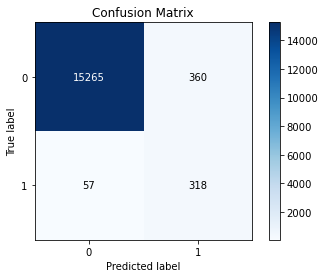

In [22]:
pred = model.predict(x_test_final)

tn, fp, fn, tp = confusion_matrix(y_test_final, pred).ravel()
skplt.metrics.plot_confusion_matrix(y_test_final, pred, normalize=False)
plt.show()

**CLASSFICATION REPORT BEFORE FEATURE SELECTION**

In [23]:
# Classification Report
print(classification_report(y_test_final, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.47      0.85      0.60       375

    accuracy                           0.97     16000
   macro avg       0.73      0.91      0.80     16000
weighted avg       0.98      0.97      0.98     16000



**TOTAL COST BEFORE FEATURE SELECTION**

In [24]:
# Total Cost before Feature Selection
# Good condition but predicted as faulty, cost of 10 for maintainance fee
cost_1 = 10
# Faulty but predicted as good condition, cost of 500 for maintainance fee
cost_2 = 500

cost = fp * cost_1 + fn * cost_2
cost

32100

**FEATURE SELECTION**

In [25]:
# Selecting the Best important features according to Logistic Regression using SelectFromModel
sfm_logreg = SelectFromModel(estimator=LogisticRegression(max_iter=1000))
sfm_logreg.fit(x_train_final, y_train_final)
feature_selected_tmp = x_train_final.columns[sfm_logreg.get_support()]
feature_selected_tmp

Int64Index([  0,   5,   6,   7,  10,  11,  15,  21,  22,  23,  24,  33,  37,
             38,  39,  45,  46,  50,  51,  61,  66,  67,  70,  71,  74,  75,
             78,  79,  87,  91,  92,  93,  95,  96, 103, 104, 108, 111, 120,
            125, 128, 138, 148, 149, 150, 153, 154, 155],
           dtype='int64')

In [26]:
feature_selected = feature_selected_tmp
x_train_final_fs = x_train_final.iloc[:,feature_selected]
x_train_final_fs.head()

,0,5,6,7,10,11,15,21,22,23,...,120,125,128,138,148,149,150,153,154,155
0,0.119381,-0.010762,-0.02837,-0.056929,0.103186,0.518102,0.180223,0.192095,0.098135,0.250203,...,0.118646,-0.025984,-0.008511,0.691140,0.098933,0.363023,0.693832,0.070072,0.008264,-0.107586
1,-0.180697,-0.010762,-0.02837,-0.056929,-0.136995,0.018291,-0.097959,-0.114016,-0.126996,0.028432,...,-0.159759,-0.025984,-0.008511,0.035477,-0.026471,0.017670,-0.018901,-0.131171,-0.184975,-0.152281
2,-0.125811,-0.010762,-0.02837,-0.056929,-0.224093,0.060103,-0.136196,-0.138391,-0.120147,-0.226663,...,-0.159759,-0.025984,-0.008511,-0.137559,-0.193951,-0.127386,-0.144217,0.016053,-0.009047,-0.107547
3,-0.407928,-0.010762,-0.02837,-0.056929,-0.337275,-0.423800,-0.431938,-0.443135,-0.439288,-0.321057,...,-0.159759,-0.025984,-0.008511,-0.455679,-0.300630,-0.304145,-0.385361,-0.351244,-0.310645,-0.199493
4,0.010572,-0.010762,-0.02837,-0.056929,0.267632,0.038748,0.041496,-0.027601,-0.054547,0.019820,...,-0.159759,-0.025984,-0.008511,0.607223,-0.134566,0.048997,0.155656,-0.039892,-0.040823,-0.018211


In [27]:
x_test_final_fs = x_test_final.iloc[:,feature_selected]
x_test_final_fs.head()

,0,5,6,7,10,11,15,21,22,23,...,120,125,128,138,148,149,150,153,154,155
0,-0.134924,-0.018614,-0.02299,-0.058136,-0.320166,-0.417622,-0.420084,-0.430768,-0.426580,-0.280959,...,-0.471993,-0.031956,-0.017995,-0.435046,-0.269070,-0.314701,-0.369541,-0.337213,-0.295763,-0.215305
1,-0.134881,-0.018614,-0.02299,-0.058136,-0.317756,-0.417179,-0.419804,-0.429385,-0.425405,-0.306654,...,-0.471993,-0.031956,-0.017995,-0.435157,-0.268186,-0.314640,-0.369565,-0.337643,-0.295757,-0.215074
2,-0.003962,-0.018614,-0.02299,-0.058136,0.217536,-0.306038,-0.003564,-0.004347,0.017304,-0.031999,...,-0.471993,-0.031956,-0.017995,0.095922,-0.133630,-0.103304,0.026325,-0.122468,0.806803,-0.120439
3,-0.016248,-0.018614,-0.02299,-0.058136,-0.049612,-0.002281,-0.029786,-0.011362,-0.014943,-0.122118,...,1.753134,-0.031956,-0.017995,0.157886,-0.041932,-0.042670,0.062984,0.049851,0.065875,-0.085608
4,-0.131441,-0.018614,-0.02299,-0.058136,-0.316285,-0.397578,-0.410154,-0.420609,-0.415701,-0.309809,...,-0.471993,-0.031956,-0.017995,-0.427279,-0.268125,-0.312013,-0.364293,-0.297980,-0.293166,-0.215062


**LOGISTIC REGRESSION MODEL ACCURACY AFTER FEATURE SELECTION**

In [28]:
model_fs = LogisticRegression(max_iter=1000)
model_fs.fit(x_train_final_fs, y_train_final)
model_fs_score = model_fs.score(x_test_final_fs, y_test_final) * 100

print("Model Accuracy without Feature Selection: {:.4f}%".format(model_score))
print("Model Accuracy with Feature Selection: {:.4f}%".format(model_fs_score))

Model Accuracy without Feature Selection: 97.3937%
Model Accuracy with Feature Selection: 97.8312%


**CONFUSION MATRIX AFTER FEATURE SELECTION**

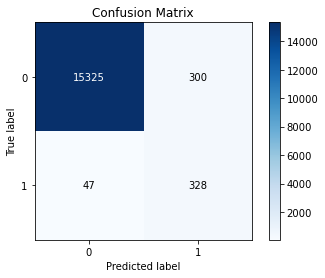

In [29]:
pred_fs = model_fs.predict(x_test_final_fs)
tn, fp, fn, tp = confusion_matrix(y_test_final, pred_fs).ravel()
skplt.metrics.plot_confusion_matrix(y_test_final, pred_fs, normalize=False)
plt.show()

**CLASSIFICATION REPORT AFTER FEATURE SELECTION**

In [30]:
# Classification Report after feature selection
print(classification_report(y_test_final, pred_fs))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.52      0.87      0.65       375

    accuracy                           0.98     16000
   macro avg       0.76      0.93      0.82     16000
weighted avg       0.99      0.98      0.98     16000



**TOTAL COST AFTER FEATURE SELECTION**

In [31]:
# Total Cost after Feature Selection
# Good condition but predicted as faulty, cost of 10 for maintainance fee
cost_1 = 10
# Faulty but predicted as good condition, cost of 500 for maintainance fee
cost_2 = 500

cost_fs = fp * cost_1 + fn * cost_2
cost_fs

26500

**LOGISTICS REGRESSION SUMMARY**

In [32]:
print("Model Accuracy without Feature Selection: {:.4f}%".format(model_score))
print("Model Accuracy with Feature Selection: {:.4f}%".format(model_fs_score))

print("Total Cost without Feature Selection: {:.0f}".format(cost))
print("Total Cost with Feature Selection: {:.0f}".format(cost_fs))

Model Accuracy without Feature Selection: 97.3937%
Model Accuracy with Feature Selection: 97.8312%
Total Cost without Feature Selection: 32100
Total Cost with Feature Selection: 26500


## 3. MODEL DEVELOPMENT - RANDOM FOREST

**RANDOM FOREST MODEL ACCURACY WITH FEATURE SELECTION**

In [33]:
model_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1)
model_rf.fit(x_train_final_fs, y_train_final)
model_rf_score = model_rf.score(x_test_final_fs, y_test_final) * 100
print("Random Forest Model Accuracy with Feature Selection: {:.4f}%".format(model_rf_score))

Random Forest Model Accuracy with Feature Selection: 97.8750%


**RANDOM FOREST MODEL CONFUSION MATRIX**

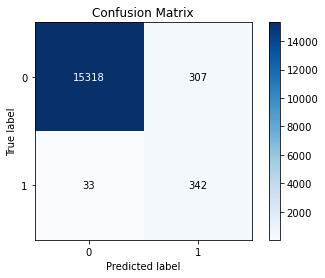

In [34]:
pred_rf = model_rf.predict(x_test_final_fs)
tn, fp, fn, tp = confusion_matrix(y_test_final, pred_rf).ravel()
skplt.metrics.plot_confusion_matrix(y_test_final, pred_rf, normalize=False)
plt.show()

**RANDOM FOREST MODEL TOTAL COST**

In [35]:
cost_rf = fp * cost_1 + fn * cost_2
print("Random Forest Model Total Cost with Feature Selection: {:.0f}".format(cost_rf))

Random Forest Model Total Cost with Feature Selection: 19570


**RANDOM FOREST CLASSFICATION REPORT WITH FEATURE SELECTION**

In [36]:
# Random Forest Classification Report
print(classification_report(y_test_final, pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.53      0.91      0.67       375

    accuracy                           0.98     16000
   macro avg       0.76      0.95      0.83     16000
weighted avg       0.99      0.98      0.98     16000



**RANDOM FOREST SUMMARY**

In [37]:
print("Random Forest Model Accuracy with Feature Selection: {:.4f}%".format(model_rf_score))
print("Random Forest Model Total Cost with Feature Selection: {:.0f}".format(cost_rf))

Random Forest Model Accuracy with Feature Selection: 97.8750%
Random Forest Model Total Cost with Feature Selection: 19570
